# Spiking multicompartment PC network

## Abstract
Predictive coding is a promising theoretical framework for understanding the hierarchical sensory processing in the brain, yet how it is implemented with cortical spiking neurons is still unclear. While most existing works have taken a hand-wiring approach to creating microcircuits which match experimental results, recent work in applying the optimisation approach revealed that cortical connectivity might result from self-organisation given some fundamental computational principle, ie. energy efficiency. We thus investigated whether predictive coding properties in a multicompartment spiking neural network can result from energy optimisation. We found that only the model trained with an energy objective in addition to a task-relevant objective was able to reconstruct internal representations given top-down expectation signals alone. Neurons in the energy-optimised model also showed differential responses to expected vs unexpected stimuli, qualitatively similar to experimental evidence for predictive coding. These findings indicated that predictive-coding-like behaviour might be an emergent property of energy optimisation, providing a new perspective on how predictive coding could be achieved in the cortex.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from predcoding.snn.network import EnergySNN
from predcoding.training import train_fptt, get_stats_named_params, reset_named_params
from predcoding.experiments.eval import test
from predcoding.experiments.decoder import train_linear_proj
from predcoding.utils import count_parameters, save_checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
torch.manual_seed(999)

cpu


## Setup

### Dataloaders

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

batch_size = 200

traindata = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testdata = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# data loading
train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, shuffle=False, num_workers=2)

### Defining the network

In [4]:
# network parameters
use_alif_neurons = True  # whether use adaptive neuron or not
clf_alpha = 1
energy_alpha = 0.05  # - config.clf_alpha
spike_alpha = 0.0  # energy loss on spikes
num_readout = 10
one_to_one = True
lr = 1e-3
alg = "fptt"
p_dropout = 0.4
is_recurrent = False
b_0 = 0.1      # neural threshold baseline
R_m = 3         # membrane resistance
gamma = 0.5     # gradient scale
lens = 0.5
baseline_threshold = b_0

# training parameters
T = 50
K = 10  # k_updates is num updates per sequence
omega = int(T / K)  # update frequency
clip = 1.0
log_interval = 20
epochs = 35
alpha = 0.2
beta = 0.5
rho = 0.0 

In [5]:
# set input and t param
d_in = 784
d_hidden = [600, 500, 500]
n_classes = 10

# define network
model = EnergySNN(
    d_in,
    d_hidden,
    d_out=n_classes,
    is_adaptive=use_alif_neurons,
    one_to_one=one_to_one,
    p_dropout=p_dropout,
    is_recurrent=is_recurrent,
    b0=b_0,
    device=device
)
model.to(device)
# print(model)

# define new loss and optimiser
total_params = count_parameters(model)
print("total param count %i" % total_params)

# define optimiser
optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=0.0001)
# reduce the learning after 20 epochs by a factor of 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

total param count 476020


## Train & test

In [5]:
# untrained network
# test_loss, acc1 = test(model, test_loader, T)

In [ ]:
named_params = get_stats_named_params(model)
all_test_losses = []
best_acc1 = 0

for epoch in range(epochs):
    train_fptt(
        epoch,
        batch_size,
        log_interval,
        train_loader,
        model,
        named_params,
        T,
        K,
        omega,
        optimizer,
        clf_alpha,
        energy_alpha,
        spike_alpha,
        clip,
        lr,
        alpha,
        beta,
        rho
    )

    reset_named_params(named_params)

    test_loss, acc1 = test(model, test_loader, T)

    scheduler.step()

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)

    if is_best:
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "best_acc1": best_acc1,
                "optimizer": optimizer.state_dict(),
            },
            prefix="checkpoints/",
            filename="best_model.pt.tar",
        )

    all_test_losses.append(test_loss)

Train Epoch: 0 [3800/60000 (6%)]	energ: 390.967174	lr: 0.001000	train acc:49.0500	Loss: 54.490126                	Clf: 36.731866	Reg: -1.790099	Fr_p: 0.418580	Fr_r: 0.289140
Train Epoch: 0 [7800/60000 (13%)]	energ: 366.436228	lr: 0.001000	train acc:72.3250	Loss: 34.642851                	Clf: 17.206363	Reg: -0.885324	Fr_p: 0.418014	Fr_r: 0.291771
Train Epoch: 0 [11800/60000 (20%)]	energ: 357.220207	lr: 0.001000	train acc:77.3250	Loss: 32.945573                	Clf: 15.796360	Reg: -0.711798	Fr_p: 0.413816	Fr_r: 0.291733
Train Epoch: 0 [15800/60000 (26%)]	energ: 350.459910	lr: 0.001000	train acc:78.0000	Loss: 33.274104                	Clf: 16.324071	Reg: -0.572963	Fr_p: 0.409717	Fr_r: 0.291245
Train Epoch: 0 [19800/60000 (33%)]	energ: 346.626029	lr: 0.001000	train acc:80.9500	Loss: 31.714674                	Clf: 14.861490	Reg: -0.478118	Fr_p: 0.406958	Fr_r: 0.290898
Train Epoch: 0 [23800/60000 (40%)]	energ: 342.982553	lr: 0.001000	train acc:83.6250	Loss: 30.303651                	Clf: 13

100%|██████████| 50/50 [00:30<00:00,  1.66it/s]



Test set: Average loss: 0.9531, Accuracy: 6798/10000 (68%)

saving at  checkpoints/best_model.pt.tar
Train Epoch: 1 [3800/60000 (6%)]	energ: 330.759386	lr: 0.001000	train acc:88.8250	Loss: 28.927290                	Clf: 12.444719	Reg: -0.055398	Fr_p: 1.430224	Fr_r: 1.016133
Train Epoch: 1 [7800/60000 (13%)]	energ: 329.146564	lr: 0.001000	train acc:88.0250	Loss: 29.208036                	Clf: 12.799161	Reg: -0.048454	Fr_p: 0.399781	Fr_r: 0.289636
Train Epoch: 1 [11800/60000 (20%)]	energ: 327.341185	lr: 0.001000	train acc:88.3500	Loss: 28.345962                	Clf: 12.022689	Reg: -0.043786	Fr_p: 0.399571	Fr_r: 0.288833
Train Epoch: 1 [15800/60000 (26%)]	energ: 327.187489	lr: 0.001000	train acc:86.4500	Loss: 28.996906                	Clf: 12.669868	Reg: -0.032337	Fr_p: 0.398674	Fr_r: 0.288623
Train Epoch: 1 [19800/60000 (33%)]	energ: 328.349458	lr: 0.001000	train acc:88.8000	Loss: 28.085715                	Clf: 11.696363	Reg: -0.028121	Fr_p: 0.398725	Fr_r: 0.289012
Train Epoch: 1 [23800

100%|██████████| 50/50 [00:34<00:00,  1.43it/s]



Test set: Average loss: 0.9688, Accuracy: 7002/10000 (70%)

saving at  checkpoints/best_model.pt.tar
Train Epoch: 2 [3800/60000 (6%)]	energ: 319.296004	lr: 0.001000	train acc:90.6000	Loss: 24.761642                	Clf: 8.802653	Reg: -0.005811	Fr_p: 1.416110	Fr_r: 1.006354
Train Epoch: 2 [7800/60000 (13%)]	energ: 318.896139	lr: 0.001000	train acc:89.5250	Loss: 24.705159                	Clf: 8.761852	Reg: -0.001500	Fr_p: 0.396311	Fr_r: 0.286939
Train Epoch: 2 [11800/60000 (20%)]	energ: 319.203751	lr: 0.001000	train acc:90.7000	Loss: 24.328900                	Clf: 8.371858	Reg: -0.003147	Fr_p: 0.396540	Fr_r: 0.286649
Train Epoch: 2 [15800/60000 (26%)]	energ: 318.942050	lr: 0.001000	train acc:88.6250	Loss: 26.126554                	Clf: 10.182688	Reg: -0.003237	Fr_p: 0.394858	Fr_r: 0.286538
Train Epoch: 2 [19800/60000 (33%)]	energ: 318.067612	lr: 0.001000	train acc:90.5500	Loss: 24.840293                	Clf: 8.936021	Reg: 0.000891	Fr_p: 0.395055	Fr_r: 0.286184
Train Epoch: 2 [23800/6000

100%|██████████| 50/50 [00:29<00:00,  1.68it/s]



Test set: Average loss: 0.5562, Accuracy: 8330/10000 (83%)

saving at  checkpoints/best_model.pt.tar
Train Epoch: 3 [3800/60000 (6%)]	energ: 316.918734	lr: 0.001000	train acc:91.7000	Loss: 24.220710                	Clf: 8.376674	Reg: -0.001901	Fr_p: 1.397934	Fr_r: 0.998981
Train Epoch: 3 [7800/60000 (13%)]	energ: 316.761026	lr: 0.001000	train acc:91.2250	Loss: 24.229272                	Clf: 8.389651	Reg: 0.001569	Fr_p: 0.394018	Fr_r: 0.286149
Train Epoch: 3 [11800/60000 (20%)]	energ: 317.798767	lr: 0.001000	train acc:90.6750	Loss: 24.652852                	Clf: 8.764057	Reg: -0.001144	Fr_p: 0.394076	Fr_r: 0.285640
Train Epoch: 3 [15800/60000 (26%)]	energ: 317.446925	lr: 0.001000	train acc:88.5250	Loss: 25.868836                	Clf: 9.995905	Reg: 0.000584	Fr_p: 0.392855	Fr_r: 0.285459
Train Epoch: 3 [19800/60000 (33%)]	energ: 317.166155	lr: 0.001000	train acc:91.1250	Loss: 23.679117                	Clf: 7.818160	Reg: 0.002649	Fr_p: 0.395367	Fr_r: 0.285757
Train Epoch: 3 [23800/60000 (

100%|██████████| 50/50 [00:33<00:00,  1.48it/s]



Test set: Average loss: 0.4976, Accuracy: 8460/10000 (85%)

saving at  checkpoints/best_model.pt.tar
Train Epoch: 4 [3800/60000 (6%)]	energ: 314.617987	lr: 0.001000	train acc:92.0000	Loss: 22.703818                	Clf: 6.974859	Reg: -0.001941	Fr_p: 1.398164	Fr_r: 0.998688
Train Epoch: 4 [7800/60000 (13%)]	energ: 313.126745	lr: 0.001000	train acc:91.4250	Loss: 23.137596                	Clf: 7.482856	Reg: -0.001597	Fr_p: 0.394206	Fr_r: 0.285080
Train Epoch: 4 [11800/60000 (20%)]	energ: 313.812318	lr: 0.001000	train acc:91.8000	Loss: 22.890770                	Clf: 7.200889	Reg: -0.000735	Fr_p: 0.393201	Fr_r: 0.284823
Train Epoch: 4 [15800/60000 (26%)]	energ: 314.007093	lr: 0.001000	train acc:90.4000	Loss: 24.013670                	Clf: 8.312645	Reg: 0.000670	Fr_p: 0.393731	Fr_r: 0.285369
Train Epoch: 4 [19800/60000 (33%)]	energ: 314.130572	lr: 0.001000	train acc:91.7250	Loss: 23.219591                	Clf: 7.512708	Reg: 0.000354	Fr_p: 0.393108	Fr_r: 0.285215
Train Epoch: 4 [23800/60000 

100%|██████████| 50/50 [00:34<00:00,  1.44it/s]



Test set: Average loss: 0.3455, Accuracy: 8888/10000 (89%)

saving at  checkpoints/best_model.pt.tar
Train Epoch: 5 [3800/60000 (6%)]	energ: 313.251728	lr: 0.001000	train acc:92.3250	Loss: 22.466409                	Clf: 6.803832	Reg: -0.000009	Fr_p: 1.381197	Fr_r: 0.997456
Train Epoch: 5 [7800/60000 (13%)]	energ: 313.054549	lr: 0.001000	train acc:91.4500	Loss: 23.158213                	Clf: 7.505762	Reg: -0.000276	Fr_p: 0.393525	Fr_r: 0.284882


KeyboardInterrupt: 

## Clamping

In [6]:
from predcoding.utils import model_result_dict_load
saved_dict = model_result_dict_load('./checkpoints/best_model.pt.tar')
model.load_state_dict(saved_dict['state_dict'])

<All keys matched successfully>

In [8]:
model.eval()
test(model, test_loader, T)

100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


Test set: Average loss: 0.3450, Accuracy: 8893/10000 (89%)



(0.3450206427574158, tensor(88.9300))

In [9]:
# get params and put into dict
param_names_wE = []
param_dict_wE = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        param_names_wE.append(name)

print(param_names_wE)

['input_layer.weight', 'input_layer.bias', 'output_layer.tau_m', 'output_layer.fc.weight', 'output_layer.fc.bias']


In [20]:
from predcoding.experiments.decoder import get_states

# clamped generation of internal representations
no_input = torch.zeros((1, d_in)).to(device)
clamp_T = T * 5


l1_clamp_E = np.zeros((10, d_hidden[0]))
l2_clamp_E = np.zeros((10, d_hidden[1]))
l3_clamp_E = np.zeros((10, d_hidden[2]))


for i in tqdm(range(10)):
    with torch.no_grad():
        model.eval()

        hidden_i, readout_i = model.init_hidden(1)

        _, hidden_gen_E_ = model.clamped_generate(i, no_input, hidden_i, readout_i, clamp_T, clamp_value=1)

        #
        l1_E = get_states([hidden_gen_E_], 0, d_hidden[0], batch_size=1, T=clamp_T, num_samples=1)
        l2_E = get_states([hidden_gen_E_], 1, d_hidden[1], batch_size=1, T=clamp_T, num_samples=1)
        l3_E = get_states([hidden_gen_E_], 2, d_hidden[2], batch_size=1, T=clamp_T, num_samples=1)

        print(l1_E.shape)

        l1_clamp_E[i] += np.squeeze(l1_E.mean(axis=1))
        l2_clamp_E[i] += np.squeeze(l2_E.mean(axis=1))
        l3_clamp_E[i] += np.squeeze(l3_E.mean(axis=1))

    torch.cuda.empty_cache()

 10%|█         | 1/10 [00:00<00:02,  3.32it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


 20%|██        | 2/10 [00:00<00:02,  3.18it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


 30%|███       | 3/10 [00:00<00:02,  3.35it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


 40%|████      | 4/10 [00:01<00:02,  2.87it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


 50%|█████     | 5/10 [00:01<00:01,  2.84it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


 60%|██████    | 6/10 [00:02<00:01,  2.85it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


 70%|███████   | 7/10 [00:02<00:01,  2.91it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


 80%|████████  | 8/10 [00:02<00:00,  2.83it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


 90%|█████████ | 9/10 [00:03<00:00,  2.76it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

GET_STATES SHAPE (1, 250, 1, 600)
TRANSPOSE SHAPE (1, 1, 250, 600)
SHAPES (1, 250, 600)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
GET_STATES SHAPE (1, 250, 1, 500)
TRANSPOSE SHAPE (1, 1, 250, 500)
SHAPES (1, 250, 500)
(1, 250, 600)


  0%|          | 0/20 [00:00<?, ?it/s]

0 train loss: 0.2183


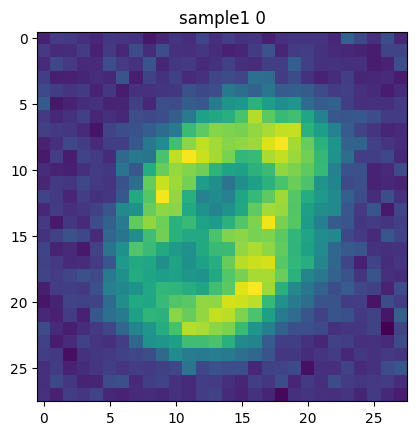

  5%|▌         | 1/20 [00:35<11:20, 35.79s/it]

In [ ]:
##############################################################
# decode from clamped representations
##############################################################
no_input = torch.zeros((1, d_in)).to(device)

fn_loss = nn.MSELoss()
test_loader2 = torch.utils.data.DataLoader(
    testdata, batch_size=batch_size, shuffle=False, num_workers=2
)

# %%
def plot_projection(rep, label, weights, bias):
    img = (weights @ rep + bias).reshape(28, 28)
    plt.imshow(img)
    plt.title(str(label))
    plt.show()
    return img


# %%
layer = 1
l2_E_decoder, loss_E = train_linear_proj(
    layer, model, test_loader2, d_hidden[layer], d_in, batch_size, T, device, fn_loss
)

decoders = [l2_E_decoder]

# %%
# plot loss curve of training
colors = [
    (0.1271049596309112, 0.4401845444059977, 0.7074971164936563),
    (0.9949711649365629, 0.5974778931180315, 0.15949250288350636),
]
sns.set_style("whitegrid", {"axes.grid": False})

fig, ax = plt.subplots(figsize=(5, 4))
plt.rcParams.update({"font.size": 14})

ax.plot(loss_E, label="Energy L%i" % (layer + 1), color=colors[0])
ax.legend()
# frame off
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("MES loss")
ax.set_xlabel("steps")
plt.legend(frameon=False)
# increase font size
plt.show()

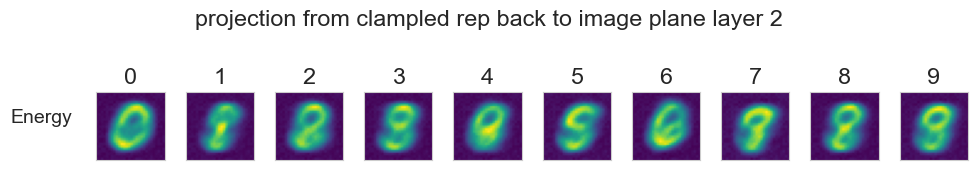

In [ ]:
# plot decoding of clamped internal representations
fig, axes = plt.subplots(1, 10, figsize=(10, 2))

with torch.no_grad():
    for proj_class in range(n_classes):
        img1 = (
            decoders[0](
                torch.tensor(l2_clamp_E[proj_class].astype("float32"))
                .to(device)
                .view(-1, d_hidden[layer])
            )
            .reshape(28, 28)
            .cpu()
        )
        axes[proj_class].imshow(img1, cmap="viridis")
        axes[proj_class].set_title(str(proj_class))
        # axes[0][proj_class].axis('off')
        axes[proj_class].tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )

fig.suptitle("projection from clampled rep back to image plane layer %i" % (layer + 1))
axes[0].set_ylabel("Energy", rotation=0, labelpad=40)

plt.tight_layout()
plt.show()